In [1]:
from clearml import Task
import configparser
import json
from tqdm import tqdm
from task_processing import remote2local, TaskListPipeline, plot_eps_bars, plot_no_privacy_unfair
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100

In [2]:
def get_credentials(dir_, file):
    if file is not None:
        config = configparser.ConfigParser()
        config.read(f'{dir_}/{file}.conf')

        # Get the values of the different settings
        api_server = config.get('settings', 'api_server')
        web_server = config.get('settings', 'web_server')
        files_server = config.get('settings', 'files_server')

        # Parse the credentials JSON string
        credentials_json = config.get('settings', 'credentials')
        credentials = json.loads(credentials_json)
        access_key = credentials['access_key']
        secret_key = credentials['secret_key']
        return api_server, web_server, files_server, access_key, secret_key
    else:
        return None, None, None, None, None

In [3]:
configuration = {
    'config_dir': 'configs',
    'server': 'local_server',
    'project_name': "AI Fairness",
    'status': ['completed'],
    'type': ['training'],
    'system_tags': ['-archived'],
    'tags': [],
    'task_name': None
}

In [4]:
api_server, web_server, files_server, access_key, secret_key = get_credentials(configuration['config_dir'], configuration['server'])
if api_server is not None:
    Task.set_credentials(
        api_host=api_server, web_host=web_server, files_host=files_server,
        key=access_key, secret=secret_key
     )
else:
    print('Use default clearml.conf')

In [5]:
task_filter={
    # filter out archived Tasks
    'system_tags': configuration['system_tags'],
    # only completed & published Tasks
    'status': configuration['status'],
    # only training type Tasks
    'type': configuration['type']
}
tags = configuration['tags']
project_name = configuration['project_name']
task_name = configuration['task_name']

task_list_ = Task.query_tasks(
    project_name=project_name,  # Optional[str]
    task_name=task_name,  # Optional[str]
    task_filter=task_filter,
    tags=tags
)
task_list_ = [Task.get_task(task_id=i) for i in tqdm(task_list_)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:33<00:00, 22.38it/s]


In [6]:
task_list = remote2local(task_list_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [01:20<00:00,  9.40it/s]


In [7]:
datasets = ['Adult', 'German']
archs = ['DP', 'EOD']
awidths = [32, 64]
privacy_ins = [['encoder_classifier'], ['encoder_classifier', 'adversary']]
eps = [1, 3, 10, 30]
metrics = ['ΔDP', 'ΔEOD', 'Accuracy']

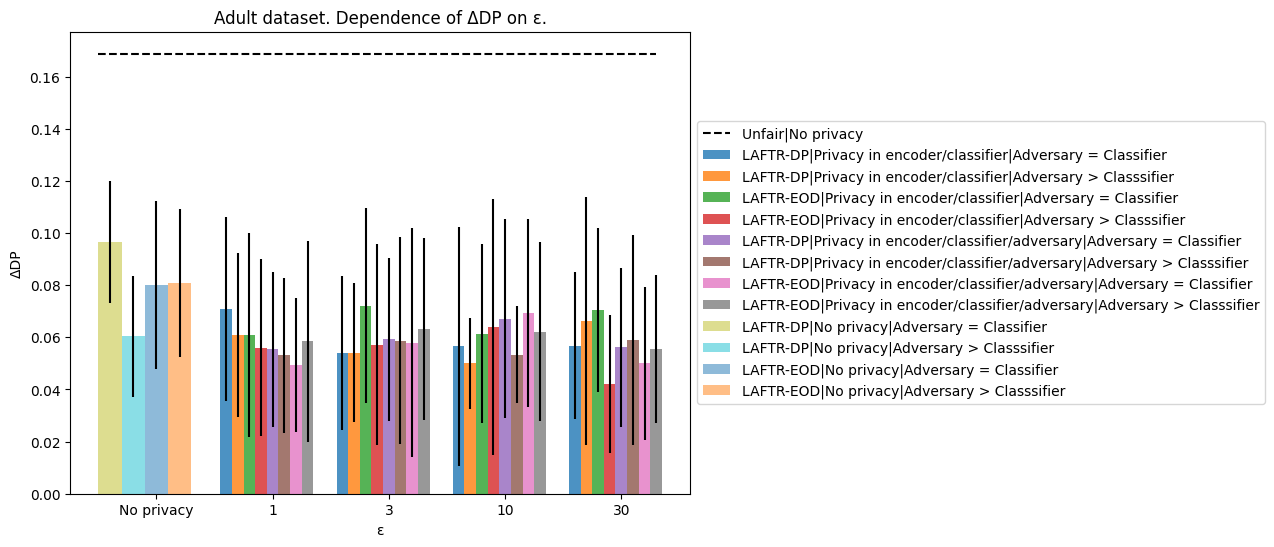

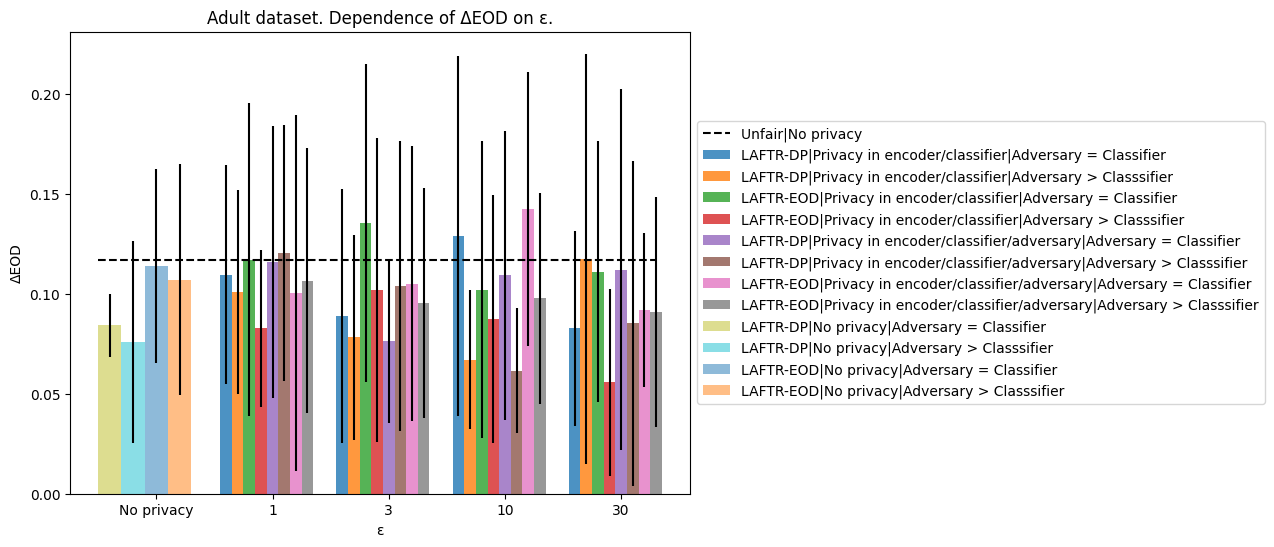

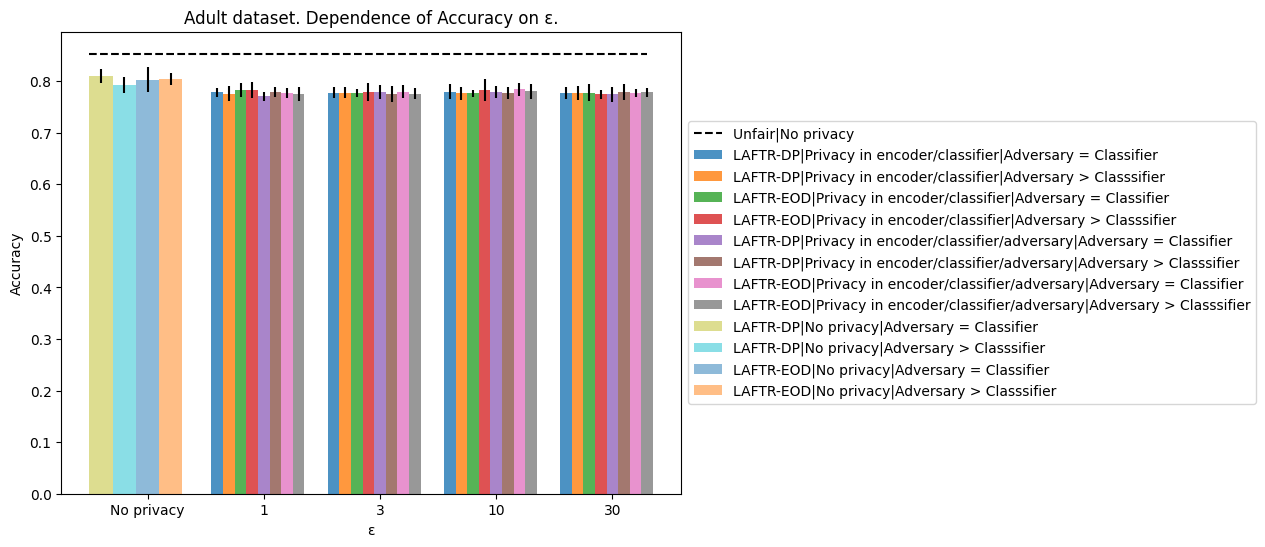

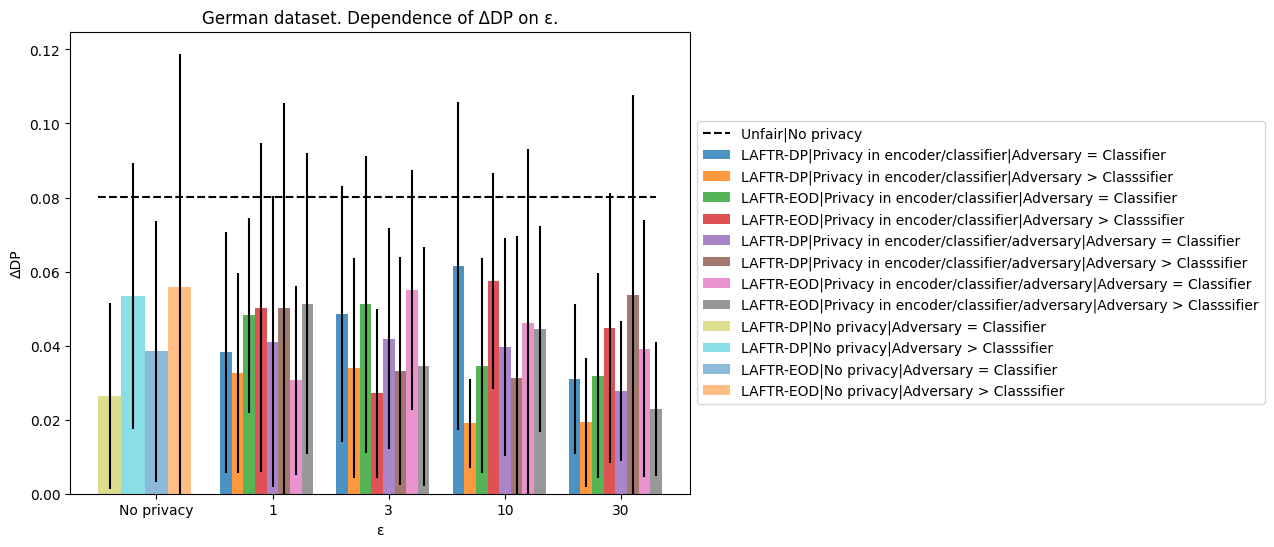

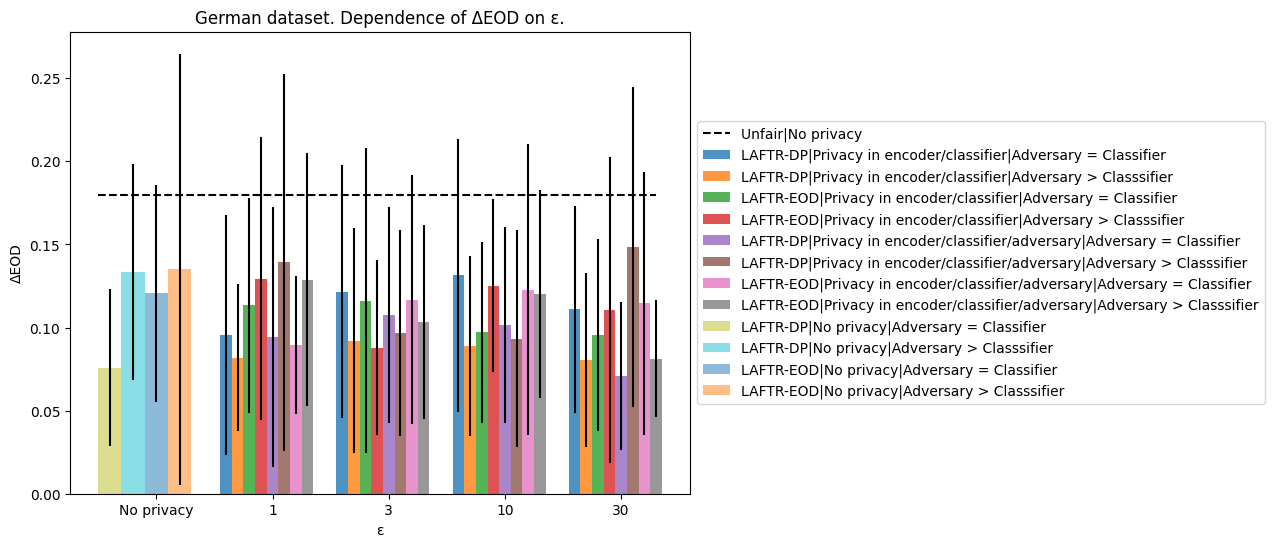

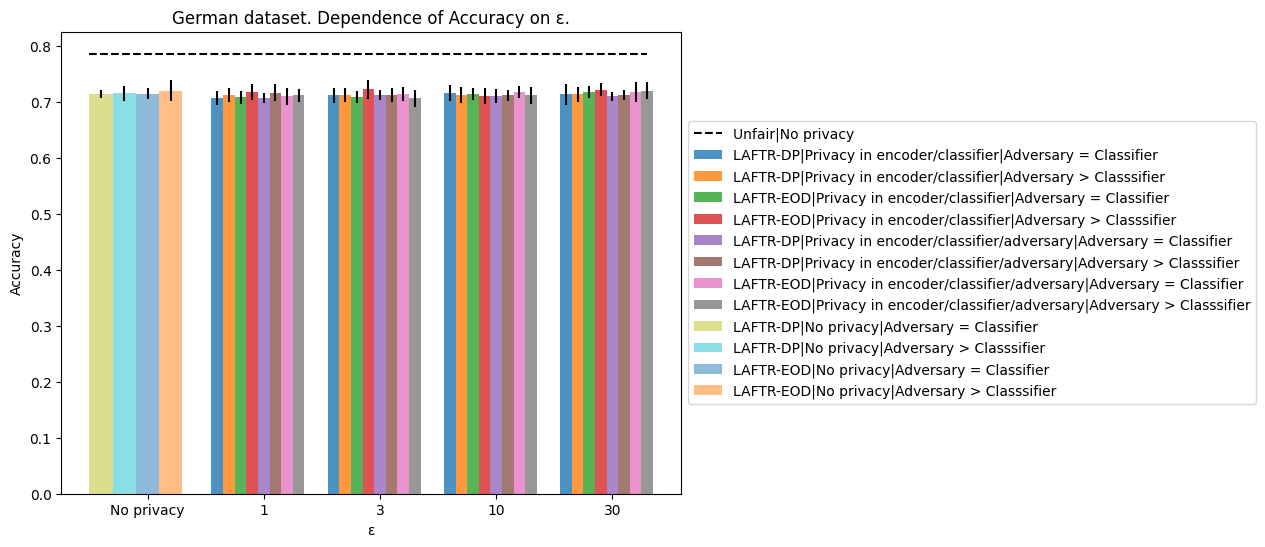

In [8]:
for dataset in datasets:
    for metric in metrics:
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 6))
        max_val = plot_eps_bars(ax, dataset, task_list, metric, privacy_ins, archs, awidths, eps)
        plot_no_privacy_unfair(ax, dataset, task_list, metric, privacy_ins, archs, awidths, eps, max_val)